## Core

- Measure fluxes from a region at multiple frequencies



In [8]:
import numpy as np
from astropy.io import ascii, fits
import fluxInt
import pbCorr
import synCl
import convRegr
from prettytable import PrettyTable
import shutil,os
import fitSource


ftSrc = fitSource.fitSrc()
fint = fluxInt.flInt()
cvReg = convRegr.cvRegr()
pb = pbCorr.pbcorr()
syn = synCl.synClean()

rootDir = '/home/maccagni/Projects/MFS/FornaxA/contData/Core/'
imDir = rootDir+'inIms/'

fint.rootdir = rootDir
syn.rootdir = rootDir
pb.rootdir = rootDir

aut='KKK'
tableName = rootDir+'coreFileNamesCvRg'+aut+'.tbl'
tableFileNames= ascii.read(tableName,format='csv')

print tableFileNames.columns[0]

print '''\t+---------+\n\t Inputs loaded\n\t+---------+'''


                                       FileName                                       
--------------------------------------------------------------------------------------
/home/maccagni/Projects/MFS/FornaxA/contData/Core/inIms/Meer_1030MHz_pbcorr_cv_rg.fits
/home/maccagni/Projects/MFS/FornaxA/contData/Core/inIms/Meer_1440MHz_pbcorr_cv_rg.fits
 /home/maccagni/Projects/MFS/FornaxA/contData/Core/inIms/VLA_4860MHz_pbcorr_cv_rg.fits
  /home/maccagni/Projects/MFS/FornaxA/contData/Core/inIms/VLA_15GhzB_pbcorr_cv_rg.fits
           /home/maccagni/Projects/MFS/FornaxA/contData/Core/inIms/ALMA_108GHz_rg.fits
	+---------+
	 Inputs loaded
	+---------+


We measure the flux in 6 frequency interval centred at: 

- 1.030 GHz (MeerKAT)
- 1.440 GHz (MeerKAT)
- 1.500 GHz (VLA)
- 4.800 GHz (VLA)
- 14.00 GHz (VLA)
- 108.0 GHz (ALMA)


We measure the flux in each map at its original spatial resolution. Since the images have very different fields of view, we draw a broad region in the centre that includes the core in all images. We measure as flux all signal above 3$\cdot$ r.m.s of the image.

The noise of the MeerKAT images (and VLA at 1500 MHz) is given in the input table, since it needs to be measured outside the extended radio lobes, that otherwise would be included in the measurement.


- We measure the fluxes following 2 different methods
    - Total flux of innermost 1.5 kpc. 
    - Total flux of the central beam and of the outer regions
    
(Total flux is measured setting a cutoff at $3\sigma$ the noise level.

In [9]:
#-------------------------------------------------#
# Total flux of innermost 1.5 kpc
#-------------------------------------------------#
region = imDir+'cReg.reg'
noise = tableFileNames.columns[2]
errFlux =tableFileNames.columns[3]

fr=[]
flIntArray=[]
flErrArray=[]

for i in xrange(0,len(tableFileNames.columns[0])):

    fileName =tableFileNames.columns[0][i]
#for i in xrange(0,len(fileNames)):
    datas,heads = fint.openFile(fileName)
    datas=np.squeeze(datas)
    heads=fint.cleanHead(heads)
    maskedData, background, rms, pixels=fint.maskDatReg(datas,heads,region,noise[i])

    noiseInt = rms *np.sqrt(pixels)
    
    if 'Frequency' in tableFileNames.dtype.names:
        freq = float(tableFileNames.columns[1][i])*1e6
        fr.append(freq)
                
    fluxint, numPixBeam =fint.measFlux(maskedData,heads,errFlux)
    flIntArray.append(fluxint)
    
    t,flErr = fint.writeTable(heads,fluxint,noiseInt,numPixBeam,freq,errFlux[i],'CoreFluxes.tbl')
    flErrArray.append(flErr)

    
syn.writeSynageTable(fr,flIntArray,flErrArray,'Core')

print '''\t+---------+\n\t Fluxes measured\n\t+---------+'''
  

IOError: File-like object does not have a 'write' method, required for mode 'ostream'.

In [10]:
#-------------------------------------------------#
# Total flux of central beam and of outer region
#-------------------------------------------------#

region = imDir+'cReg.reg'
regAlma = imDir+'cRegAL.reg'
noise = tableFileNames.columns[2]
errFlux =tableFileNames.columns[3]

aut='KKK'

outBeam='CoreBeamFluxes'+aut+'.tbl'
if os.path.exists(rootDir+outBeam):
    os.remove(rootDir+outBeam)
outOut='CoreOutFluxes'+aut+'.tbl'
if os.path.exists(rootDir+outOut):
    os.remove(rootDir+outOut)
fr=[]
flIntBeamArray=[]
flErrBeamArray=[]
flIntOutArray=[]
flErrOutArray=[]

for i in xrange(0,len(tableFileNames.columns[0])):
    #fileName = rgFileNames[i]
    fileName = tableFileNames.columns[0][i]
#for i in xrange(0,len(fileNames)):
    fileName=fint.cleanHead(fileName)
    datas,heads = fint.openFile(fileName)
    #if i == 4: 
    #    region=regAlma
    maskedData, background, rms, pixels=fint.maskDatReg(datas,heads,region,noise[i])
    
    pixelsOut = np.count_nonzero(~np.isnan(maskedData))
   
    maskedData[np.isnan(maskedData)] = 0.0
    
    params = ftSrc.gaus2Dfit(maskedData)
    
    peak =  params[0]
    
    print params
    peak = np.nanmax(maskedData)
    print fileName
    
    maskedData[maskedData==0.0] = np.nan

    fluxint, numPixBeam =fint.measFlux(maskedData,heads,errFlux)

    maskedData[~np.isnan(maskedData)] = 1.
    fits.writeto(rootDir+str(i)+'_mask.fits',maskedData,heads,overwrite=True)
    fluxintOut = fluxint - peak
    print fluxint, peak, fluxintOut
    #xl =  np.arange(1, heads['NAXIS1']+1, 1)
    #yl = np.arange(1, heads['NAXIS2']+1,1)
    #x,y = np.meshgrid(xl,yl)

    #beamA = float(heads['BMAJ'])/float(heads['CDELT2'])
    #beamB = float(heads['BMIN'])/float(heads['CDELT2'])
    #ctr =  np.unravel_index(np.nanargmax(maskedData, axis=None), maskedData.shape)
    #print ctr
    #print np.nanmax(maskedData)
    #print np.nanargmax(maskedData, axis=None)
    
    
    #indexBeam = np.divide(np.power(x-ctr[1]-1,2),np.power(beamA,2))+np.divide(np.power(y-ctr[0]-1,2),
    #                                                                          np.power(beamB,2)) < 1.    
    #maskedBeam = maskedData.copy()
    #maskedOut = maskedData.copy()
    
    
    #maskedOut[indexBeam==True] = np.nan
    #pixelsOut = np.count_nonzero(~np.isnan(maskedOut))
    #noiseIntOut = noise[i] #*np.sqrt(pixelsOut)

    
    #maskedBeam[indexBeam==False] = np.nan
    #pixelsBeam = np.count_nonzero(~np.isnan(maskedBeam))
    
    
    #fits.writeto(rootDir+str(i)+'_tmpBeam.fits',maskedBeam,heads,overwrite=True)
    #fits.writeto(rootDir+str(i)+'_tmpOut.fits',maskedOut,heads,overwrite=True)

    if 'Frequency' in tableFileNames.dtype.names:
        freq = float(tableFileNames.columns[1][i])*1e6
        fr.append(freq)
                
    #fluxintBeam = np.nanmax(maskedData)
    #print fluxintBeam
    #noiseIntBeam = noise[i]/numPixBeam*np.sqrt(pixelsBeam*numPixBeam)
    noiseIntBeam = noise[i]/numPixBeam

    
    flIntBeamArray.append(peak)

    t,flBeamErr = fint.writeTable(heads,peak,noiseIntBeam,numPixBeam,freq,errFlux[i],outBeam)
    flErrBeamArray.append(flBeamErr)
    
    #fluxintOut, numPixBeam =fint.measFlux(maskedOut,heads,errFlux)
    
    flIntOutArray.append(fluxintOut)

    noiseIntOut = noise[i]/numPixBeam*np.sqrt(pixelsOut*numPixBeam)

    t,flOutErr = fint.writeTable(heads,fluxintOut,noiseIntOut,numPixBeam,freq,errFlux[i],outOut)
    flErrOutArray.append(flOutErr)

    
syn.writeSynageTable(fr,flIntBeamArray,flErrBeamArray,'CoreBeam'+aut)
syn.writeSynageTable(fr,flIntOutArray,flErrOutArray,'CoreOut'+aut)
print '''\t+---------+\n\t Fluxes measured\n\t+---------+'''
  

[  0.35033925 340.16770721 331.05421283   7.35156768  11.22960214]
/home/maccagni/Projects/MFS/FornaxA/contData/Core/inIms/Meer_1030MHz_pbcorr_cv_rg.fits
0.9426240977774716 0.3985611959494052 0.5440629018280664
[  0.51464322 340.06418438 330.96645388   7.07096788  11.01981576]
/home/maccagni/Projects/MFS/FornaxA/contData/Core/inIms/Meer_1440MHz_pbcorr_cv_rg.fits
1.2822783304935517 0.5813716940555067 0.700906636438045
[  0.57980819 338.56555666 329.69011991   6.18413877  10.35895482]
/home/maccagni/Projects/MFS/FornaxA/contData/Core/inIms/VLA_4860MHz_pbcorr_cv_rg.fits
1.1074971146814654 0.6304051469240327 0.4770919677574327
[2.27403039e-01 3.39433949e+02 3.29063741e+02 5.47939363e+00
 9.86405417e+00]
/home/maccagni/Projects/MFS/FornaxA/contData/Core/inIms/VLA_15GhzB_pbcorr_cv_rg.fits
0.3288722607662319 0.23666883508878395 0.09220342567744794
[6.87024720e-03 3.37662718e+02 3.28291351e+02 4.80484763e+00
 9.13561850e+00]
/home/maccagni/Projects/MFS/FornaxA/contData/Core/inIms/ALMA_108GHz_r

**Output tables**:

```
~/Projects/MFS/FornaxA/contData/core/integratedFluxes.tbl'
~/Projects/MFS/FornaxA/contData/core/synageFlCore.tbl'
```

**...Run synage to analyse the spectral energy distribution...**

```
~/programs/synage/SYNAGE
exec synageCore.script
```

**Output SYNAGE tables**:

```
CiCore_point1_fit.dat
CiOFFCore_point1_fit.dat
```


In [12]:
statsCI = syn.readCIStats(rootDir+'synOut/CoreCI.stats')
statsCIOFF =  syn.readCIOFFStats(rootDir+'synOut/CoreCIOFF.stats')

#tot= ascii.read(rootDir+'CoreFluxes.tbl', fast_reader=False)

modCI = syn.readCIMod(rootDir+'synOut/CoreCI_point1_fit.dat')
modCIOFF = syn.readCIMod(rootDir+'synOut/CoreCIOFF_point1_fit.dat')

print '''\t+---------+\n\t Total \n\t+---------+'''
CI = PrettyTable(['CI', 'value'])
for key, val in statsCI.items():
    CI.add_row([key, val])
print CI


CIOFF = PrettyTable(['CIOFF', 'value'])
for key, val in statsCIOFF.items():
    CIOFF.add_row([key, val])
print CIOFF


statsBeamCI = syn.readCIStats(rootDir+'synOut/CoreBeam'+aut+'CI.stats')
statsBeamCIOFF =  syn.readCIOFFStats(rootDir+'synOut/CoreBeam'+aut+'CIOFF.stats')

totBeam= ascii.read(rootDir+'CoreBeamFluxes'+aut+'.tbl', fast_reader=False)

modBeamCI = syn.readCIMod(rootDir+'synOut/CoreBeam'+aut+'CI_point1_fit.dat')
modBeamCIOFF = syn.readCIMod(rootDir+'synOut/CoreBeam'+aut+'CIOFF_point1_fit.dat')

print '''\t+---------+\n\t Central Beam \n\t+---------+'''
CI = PrettyTable(['CI', 'value'])
for key, val in statsBeamCI.items():
    CI.add_row([key, val])
print CI


CIOFF = PrettyTable(['CIOFF', 'value'])
for key, val in statsBeamCIOFF.items():
    CIOFF.add_row([key, val])
print CIOFF

statsOutCI = syn.readCIStats(rootDir+'synOut/CoreOut'+aut+'CI.stats')
statsOutCIOFF =  syn.readCIOFFStats(rootDir+'synOut/CoreOut'+aut+'CIOFF.stats')

totOut= ascii.read(rootDir+'CoreOutFluxes'+aut+'.tbl', fast_reader=False)

modOutCI = syn.readCIMod(rootDir+'synOut/CoreOut'+aut+'CI_point1_fit.dat')
modOutCIOFF = syn.readCIMod(rootDir+'synOut/CoreOut'+aut+'CIOFF_point1_fit.dat')

print '''\t+---------+\n\t Outer centre \n\t+---------+'''
CI = PrettyTable(['CI', 'value'])
for key, val in statsOutCI.items():
    CI.add_row([key, val])
print CI


CIOFF = PrettyTable(['CIOFF', 'value'])
for key, val in statsOutCIOFF.items():
    CIOFF.add_row([key, val])
print CIOFF


print '''\t+---------+\n\t Synage results read\n\t+---------+'''


	+---------+
	 Total 
	+---------+
+--------------+-------------+
|      CI      |    value    |
+--------------+-------------+
| alpha_errsup |  0.1164626  |
|    break     |   101735.9  |
|    chisq     |  0.3361874  |
|    chired    |  0.1120625  |
|  break_inf   |  -101725.9  |
|    alpha     |   0.929166  |
|     ndf      |     3.0     |
| alpha_errinf |  -0.529166  |
|     norm     | 0.006200066 |
|  break_sup   |   35215.16  |
+--------------+-------------+
+--------------+--------------+
|    CIOFF     |    value     |
+--------------+--------------+
|   t_errinf   |     -0.0     |
|    tratio    |    0.001     |
|   t_errsup   | 0.0004381696 |
|    break     |   249962.8   |
|    chisq     |  0.2432288   |
|    alpha     |  0.9498693   |
| alpha_errinf |  -0.221976   |
| alpha_errsup |  0.03489188  |
|    chired    |  0.1216144   |
|     ndf      |     2.0      |
|  break_inf   |  -249952.8   |
|  break_sup   |   37.15904   |
|     norm     | 0.002366712  |
+--------------+---

In [13]:
#-------------------------------------------------#
# Plot SED
#-------------------------------------------------#
from matplotlib import pyplot as plt
from matplotlib import rc
from matplotlib import gridspec
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, LogLocator
from matplotlib import transforms as mtransforms

def plCoreJets(tot1,tot2,labe1,labe2,sed):

    params = {'font.family'         :' serif',
              'font.style'          : 'normal',
              'font.weight'         : 'book',
              'font.size'           : 30.0,
              'axes.linewidth'      : 3,
              'lines.linewidth'     : 3,
              'xtick.labelsize'     : 26,
              'ytick.labelsize'     : 26, 
              'xtick.direction'     :'in',
              'ytick.direction'     :'in',
              'xtick.top'           : True,   # draw ticks on the top side
              'xtick.bottom'        : True,   # draw ticks on the bottom side    
              'ytick.left'          : True,   # draw ticks on the top side
              'ytick.right'         : True,   # draw ticks on the bottom side  
              'xtick.major.size'    : 8,
              'xtick.major.width'   : 3,
              'xtick.minor.size'    : 4,
              'xtick.minor.width'   : 2,
              'ytick.major.size'    : 8,
              'ytick.major.width'   : 3,
              'ytick.minor.size'    : 4,
              'ytick.minor.width'   : 2, 
              'text.usetex'         : True,
              'text.latex.unicode'  : True
               }
    plt.rcParams.update(params)

    # initialize figure
    fig = plt.figure(figsize =(12,12))
    fig.subplots_adjust(hspace=0.0)
    gs = gridspec.GridSpec(1, 1)
    plt.rc('xtick')


    # Initialize subplots
    ax1 = fig.add_subplot(gs[0])
    ax1.set_xlabel(r'Frequency [MHz]')
    ax1.set_ylabel(r'Flux density [Jy]')
    #ax1.set_xscale("symlog", nonposx='clip', linthreshy=0.1)
    #ax1.set_yscale("symlog", nonposy='clip', linthreshy=0.1)
    ax1.set_xscale("log", nonposx='clip')
    ax1.set_yscale("log", nonposy='clip')
    ax1.set_ylim([1e-3,1])
    ax1.set_xlim([5e2,2e5])
    ax1.tick_params(axis='both', which='major', pad=5)

    #POINTS
    
    # MODELS
    
    #idx_max = (np.abs(mod1_CI[0] - 5e5)).argmin()
    #idx_min = (np.abs(mod1_CI[0] - 30)).argmin()

    
    totplot = ax1.errorbar(tot1['Frequency [MHz]'],tot1['Integrated Flux [Jy]'], yerr=tot1['Error [Jy]'],
             marker='o',markersize=10,color='green', linestyle=' ',label=labe1,capsize=6) 
    
    totplot = ax1.errorbar(tot2['Frequency [MHz]'],tot2['Integrated Flux [Jy]'], yerr=tot2['Error [Jy]'],
             marker='o',markersize=10, color='m', linestyle=' ',label=labe2,capsize=6)     

    totplot[-1][0].set_linestyle('--')
    totplot[-1][0].set_linewidth(3)    
    #ax1.axvline(br_f_no217,ymin=0,ymax=0.73,ls='-.',c='cyan',lw=1) 

    legend = plt.legend(loc=1, prop={'size': 30})
    legend.get_frame().set_edgecolor('black')

    # Save figure to file
    plt.savefig(sed,overwrite = True)


print '\n\t-----> Loaded <-----'


print '\n\t-----> Loaded <-----'


	-----> Loaded <-----

	-----> Loaded <-----


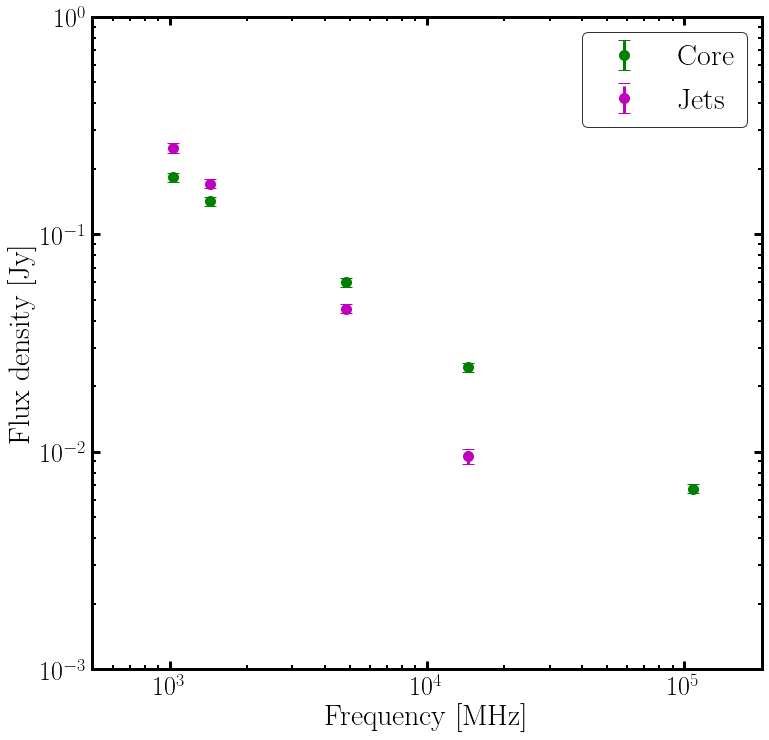

In [14]:
outplot=rootDir+'coreJets.png'
plCoreJets(totBeam,totOut,'Core','Jets',outplot)

In [15]:
#-------------------------------------------------#
# Plot SED
#-------------------------------------------------#
def plCIovCIOFFMultiReg(tot1,mod1_CI,mod1_CIOFF,stats1CI,stats1CIOFF,
                        tot2,mod2_CI,mod2_CIOFF,stats2CI,stats2CIOFF,labe1,labe2,sed):

    params = {'font.family'         :' serif',
              'font.style'          : 'normal',
              'font.weight'         : 'book',
              'font.size'           : 30.0,
              'axes.linewidth'      : 3,
              'lines.linewidth'     : 3,
              'xtick.labelsize'     : 26,
              'ytick.labelsize'     : 26, 
              'xtick.direction'     :'in',
              'ytick.direction'     :'in',
              'xtick.top'           : True,   # draw ticks on the top side
              'xtick.bottom'        : True,   # draw ticks on the bottom side    
              'ytick.left'          : True,   # draw ticks on the top side
              'ytick.right'         : True,   # draw ticks on the bottom side  
              'xtick.major.size'    : 8,
              'xtick.major.width'   : 3,
              'xtick.minor.size'    : 4,
              'xtick.minor.width'   : 2,
              'ytick.major.size'    : 8,
              'ytick.major.width'   : 3,
              'ytick.minor.size'    : 4,
              'ytick.minor.width'   : 2, 
              'text.usetex'         : True,
              'text.latex.unicode'  : True
               }
    plt.rcParams.update(params)

    # initialize figure
    fig = plt.figure(figsize =(12,12))
    fig.subplots_adjust(hspace=0.0)
    gs = gridspec.GridSpec(1, 1)
    plt.rc('xtick')


    # Initialize subplots
    ax1 = fig.add_subplot(gs[0])
    ax1.set_xlabel(r'Frequency [MHz]')
    ax1.set_ylabel(r'Flux density [Jy]')
    #ax1.set_xscale("symlog", nonposx='clip', linthreshy=0.1)
    #ax1.set_yscale("symlog", nonposy='clip', linthreshy=0.1)
    ax1.set_xscale("log", nonposx='clip')
    ax1.set_yscale("log", nonposy='clip')
    ax1.set_ylim([1e-4,2e2])
    ax1.set_xlim([50,5e5])
    ax1.tick_params(axis='both', which='major', pad=5)

    #POINTS
    
    # MODELS
    
    idx_max = (np.abs(mod1_CI[0] - 5e5)).argmin()
    idx_min = (np.abs(mod1_CI[0] - 30)).argmin()

    ax1.plot(mod1_CI[0][idx_min:idx_max],mod1_CI[1][idx_min:idx_max],lw=3, marker=' ', 
             color='darkgreen', linestyle=':',label='CI',alpha=0.5)

    idx_br = (np.abs(mod1_CI[0] - float(stats1CI['break']))).argmin()
    ax1.axvline(stats1CI['break'],ymin=0,ymax=0.58,ls=':',c='darkgreen',lw=2,alpha=0.5)

    ax1.plot(mod1_CIOFF[0][idx_min:idx_max],mod1_CIOFF[1][idx_min:idx_max],lw=3, marker=' ', 
             color='mediumseagreen', linestyle='--',label=r'CI$_{\rm OFF}$',alpha=0.5)

    idx_br = (np.abs(mod1_CIOFF[0] - float(stats1CIOFF['break']))).argmin()
    ax1.axvline(stats1CIOFF['break'],ymin=0,ymax=0.55,ls='--',c='mediumseagreen',lw=3,alpha=0.8)
    
    totplot = ax1.errorbar(tot1['Frequency [MHz]'],tot1['Integrated Flux [Jy]'], yerr=tot1['Error [Jy]'],
             marker='o', color='green', linestyle=' ',label=labe1,capsize=6) 
    
    ax1.plot(mod2_CI[0][idx_min:idx_max],mod2_CI[1][idx_min:idx_max],lw=3, marker=' ', 
             color='darkmagenta', linestyle=':',label='CI',alpha=0.5)

    idx_br = (np.abs(mod2_CI[0] - float(stats2CI['break']))).argmin()
    ax1.axvline(stats2CI['break'],ymin=0,ymax=0.58,ls=':',c='darkmagenta',lw=2,alpha=0.5)

    ax1.plot(mod2_CIOFF[0][idx_min:idx_max],mod2_CIOFF[1][idx_min:idx_max],lw=3, marker=' ', 
             color='hotpink', linestyle='--',label=r'CI$_{\rm OFF}$',alpha=0.5)

    idx_br = (np.abs(mod2_CIOFF[0] - float(stats2CIOFF['break']))).argmin()
    ax1.axvline(stats2CIOFF['break'],ymin=0,ymax=0.55,ls='--',c='hotpink',lw=3,alpha=0.8)
    
    totplot = ax1.errorbar(tot2['Frequency [MHz]'],tot2['Integrated Flux [Jy]'], yerr=tot2['Error [Jy]'],
             marker='o', color='m', linestyle=' ',label=labe2,capsize=6)     

    totplot[-1][0].set_linestyle('--')
    totplot[-1][0].set_linewidth(3)    
    #ax1.axvline(br_f_no217,ymin=0,ymax=0.73,ls='-.',c='cyan',lw=1) 

    legend = plt.legend(loc=1, prop={'size': 20})
    legend.get_frame().set_edgecolor('black')

    # Save figure to file
    plt.savefig(sed,overwrite = True)


print '\n\t-----> Loaded <-----'


	-----> Loaded <-----


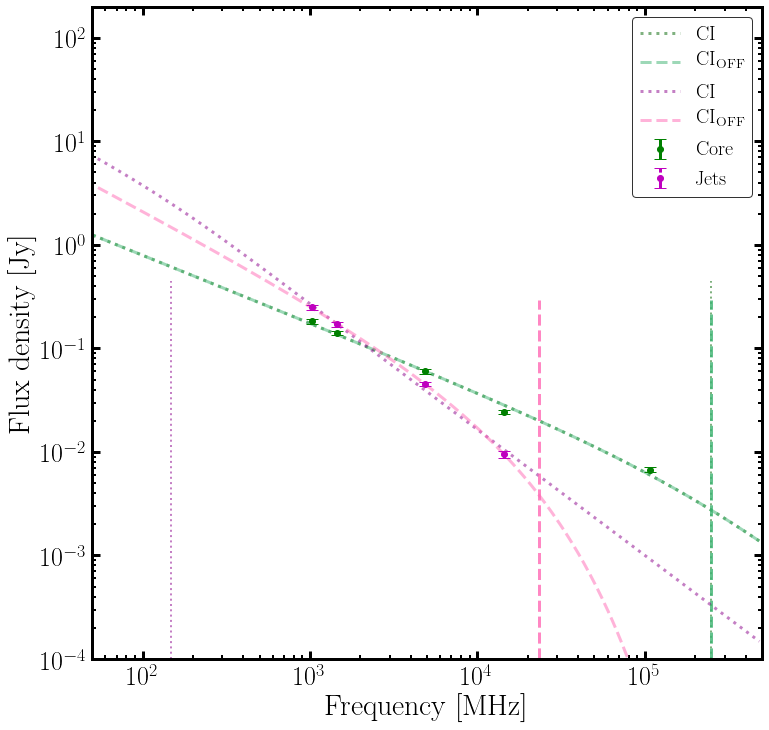

In [17]:
outplot=rootDir+'coreKKKFpeak.png'
plCIovCIOFFMultiReg(totBeam,modBeamCI,modBeamCIOFF,statsBeamCI,statsBeamCIOFF,
            totOut,modOutCI,modOutCIOFF,statsOutCI,statsOutCIOFF,'Core','Jets',outplot)

In [20]:
#-------------------------------------------------#
# Plot SED
#-------------------------------------------------#
def plCIovCIOFF(tot1,mod1_CI,mod1_CIOFF,stats1CI,stats1CIOFF,labe1,cc,sed):

    params = {'font.family'         :' serif',
              'font.style'          : 'normal',
              'font.weight'         : 'book',
              'font.size'           : 30.0,
              'axes.linewidth'      : 3,
              'lines.linewidth'     : 3,
              'xtick.labelsize'     : 26,
              'ytick.labelsize'     : 26, 
              'xtick.direction'     :'in',
              'ytick.direction'     :'in',
              'xtick.top'           : True,   # draw ticks on the top side
              'xtick.bottom'        : True,   # draw ticks on the bottom side    
              'ytick.left'          : True,   # draw ticks on the top side
              'ytick.right'         : True,   # draw ticks on the bottom side  
              'xtick.major.size'    : 8,
              'xtick.major.width'   : 3,
              'xtick.minor.size'    : 4,
              'xtick.minor.width'   : 2,
              'ytick.major.size'    : 8,
              'ytick.major.width'   : 3,
              'ytick.minor.size'    : 4,
              'ytick.minor.width'   : 2, 
              'text.usetex'         : True,
              'text.latex.unicode'  : True
               }
    plt.rcParams.update(params)

    # initialize figure
    fig = plt.figure(figsize =(12,12))
    fig.subplots_adjust(hspace=0.0)
    gs = gridspec.GridSpec(1, 1)
    plt.rc('xtick')


    # Initialize subplots
    ax1 = fig.add_subplot(gs[0])
    ax1.set_xlabel(r'Frequency [MHz]')
    ax1.set_ylabel(r'Flux density [Jy]')
    #ax1.set_xscale("symlog", nonposx='clip', linthreshy=0.1)
    #ax1.set_yscale("symlog", nonposy='clip', linthreshy=0.1)
    ax1.set_xscale("log", nonposx='clip')
    ax1.set_yscale("log", nonposy='clip')
    ax1.set_ylim([1e-3,1])
    ax1.set_xlim([5e2,3e5])
    ax1.tick_params(axis='both', which='major', pad=5)

    #POINTS
    
    # MODELS
    
    idx_max = (np.abs(mod1_CI[0] - 5e5)).argmin()
    idx_min = (np.abs(mod1_CI[0] - 30)).argmin()

    totplot = ax1.errorbar(tot1['Frequency [MHz]'],tot1['Integrated Flux [Jy]'], yerr=tot1['Error [Jy]'],
             marker='o', color=cc[0], linestyle=' ',label=labe1,capsize=6,markersize=10) 

    totplot[-1][0].set_linestyle('--')
    totplot[-1][0].set_linewidth(3)     
    
    ax1.plot(mod1_CI[0][idx_min:idx_max],mod1_CI[1][idx_min:idx_max],lw=3, marker=' ', 
             color=cc[1], linestyle=':',label='CI',alpha=0.5)

    idx_br = (np.abs(mod1_CI[0] - float(stats1CI['break']))).argmin()
    ax1.axvline(stats1CI['break'],ymin=0,ymax=0.58,ls=':',c=cc[1],lw=2,alpha=0.5)

    ax1.plot(mod1_CIOFF[0][idx_min:idx_max],mod1_CIOFF[1][idx_min:idx_max],lw=3, marker=' ', 
             color=cc[2], linestyle='--',label=r'CI$_{\rm OFF}$',alpha=0.5)

    idx_br = (np.abs(mod1_CIOFF[0] - float(stats1CIOFF['break']))).argmin()
    ax1.axvline(stats1CIOFF['break'],ymin=0,ymax=0.55,ls='--',c=cc[2],lw=3,alpha=0.8)
    
   
    #ax1.axvline(br_f_no217,ymin=0,ymax=0.73,ls='-.',c='cyan',lw=1) 

    legend = plt.legend(loc=1, prop={'size': 30})
    legend.get_frame().set_edgecolor('black')

    # Save figure to file
    plt.savefig(sed,overwrite = True)


print '\n\t-----> Loaded <-----'


	-----> Loaded <-----


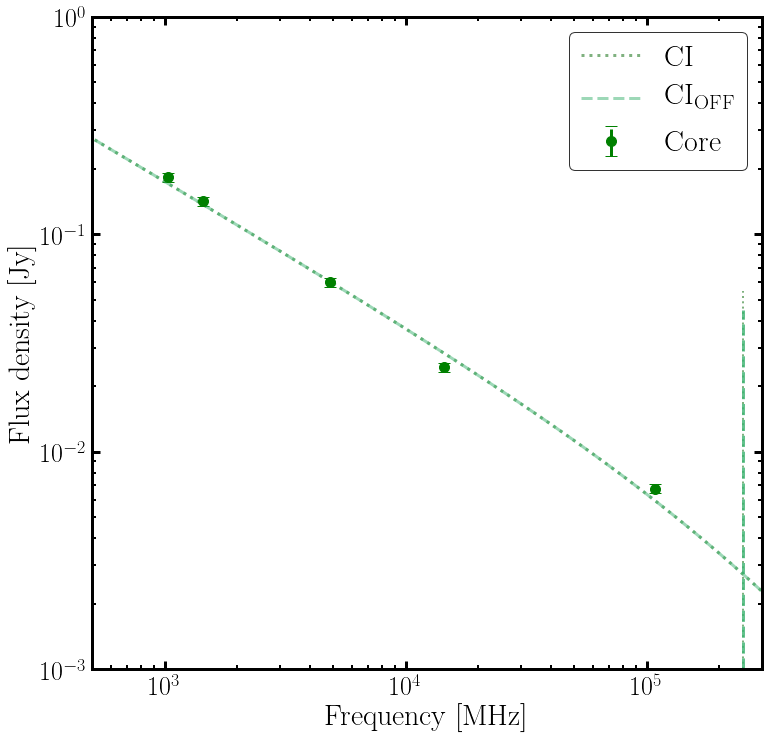

In [21]:
outplot=rootDir+'coreKKK.png'
plCIovCIOFF(totBeam,modBeamCI,modBeamCIOFF,statsBeamCI,statsBeamCIOFF,'Core',['green','darkgreen','mediumseagreen'],outplot)

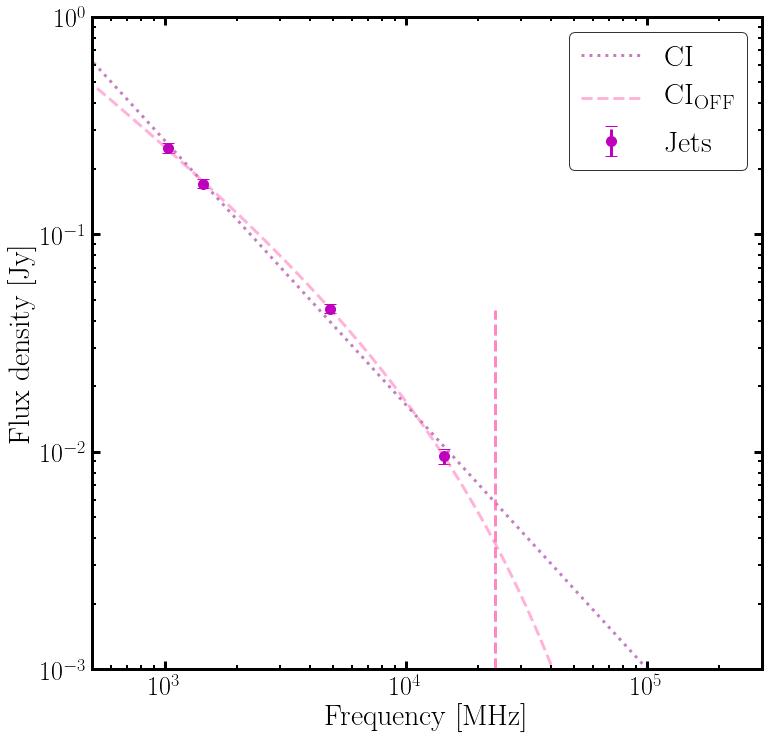

In [22]:
outplot=rootDir+'jetsKKK.png'
plCIovCIOFF(totOut,modOutCI,modOutCIOFF,statsOutCI,statsOutCIOFF,'Jets',['m','darkmagenta','hotpink'],outplot)